In [157]:
import cv2 as cv
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

In [158]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv.cvtColor( imgArray[x][y], cv.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv.cvtColor(imgArray[x], cv.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

In [159]:
def intializePredectionModel():
    model = load_model("/content/myModel.h5")
    return model

In [160]:
#step-1 retuening a preprocessed image

def preprocessing(img):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray,(5,5), 1)
    threshold = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,11,2)# APPLY ADAPTIVE THRESHOLD
    
    return threshold

In [161]:
#Step-3.1 getting the biggest contours

def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv.contourArea(i)
        if area > 50:
            peri = cv.arcLength(i,True)
            approx = cv.approxPolyDP(i,0.02*peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest,max_area

In [162]:
#Step-3.2 reordering the list of points in the biggest contours

def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

In [163]:
#Step-4.1 Splitting all the boxes in the sudoku warped image such that getting all the digits in the sudoku image

def splitting(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            boxes.append(box)
    return boxes

In [164]:
#Step-4.2 getPredictions 

def getPredictions(boxes,model):
    results = []
    for img in boxes:
        # Processing the image
        
        img = np.asarray(img) 
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv.resize(img, (28, 28))
        img = img / 255
        img = img.reshape(1, 28, 28, 1)

        # Getting the predictions

        predictions =model.predict(img)
        classIndex =np.argmax(predictions, axis=-1)
        probality_val = np.amax(predictions)
        # print(classIndex, probality_val)
        if probality_val >0.8:
            results.append(classIndex[0])
        else:
            results.append(0)
    return results

In [165]:
#Step-4 Dispalying all the number on the board 

def display_numbers(img,numbers,color= (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range(0,9):
        for y in range(0,9):
             if numbers[(y*9)+x] != 0 :
                 cv.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv.LINE_AA)
    return img
         



In [166]:
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv.line(img, pt1, pt2, (255, 255, 0),2)
        cv.line(img, pt3, pt4, (255, 255, 0),2)
    return img

In [167]:
"""
This module finds the solution of a given sudoku problem
Code credits: Tim Ruscica
More info: https://techwithtim.net/tutorials/python-programming/sudoku-solver-backtracking/
Example input board
board = [
    [7,8,0,4,0,0,1,2,0],
    [6,0,0,0,7,5,0,0,9],
    [0,0,0,6,0,1,0,7,8],
    [0,0,7,0,4,0,2,6,0],
    [0,0,1,0,5,0,9,3,0],
    [9,0,4,0,6,0,0,0,5],
    [0,7,0,3,0,0,0,1,2],
    [1,2,0,0,0,7,4,0,0],
    [0,4,9,2,0,6,0,0,7]
]
"""

def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None

In [168]:
# print('Setting UP')
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
"""
when ur using tensorflow in vscode, pycharm etc,. use these lines to hide the errors
which apperar in terminal
"""

'\nwhen ur using tensorflow in vscode, pycharm etc,. use these lines to hide the errors\nwhich apperar in terminal\n'

In [169]:
################################################################################
img_path = '/content/7.jpg'
height_img = 450
width_img = 450
model = intializePredectionModel()
################################################################################

In [170]:
## 1-Prepareing the image

img =  cv.imread(img_path)
img = cv.resize(img, (height_img, width_img))
img_blank = np.zeros((height_img, width_img, 3), np.uint8)
img_threshold = preprocessing(img)

In [171]:
## 2-Making contours in the image

img_contours = img.copy()
img_biggest = img.copy()
contours, heirarchy =cv.findContours(img_threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_contours, contours,-1,(0,255,0), 3)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [222, 204, 195],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [201, 189, 164]]

In [172]:
## 3-Find the biggest contour or shape to get the sudoku and transform it

biggest , max_area = biggestContour(contours)
# print(biggest , max_area)
if biggest.size != 0:
    biggest=reorder(biggest)
    cv.drawContours(img_biggest,biggest,-1,(0,255,0),20)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[width_img,0],[0,height_img],[width_img,height_img]])
    matrix = cv.getPerspectiveTransform(pts1,pts2)
    # print(biggest,pts1)
    Wraped_img = cv.warpPerspective(img,matrix,(width_img ,height_img))
    Detect_degits_img = img_blank.copy()
    Wraped_img = cv.cvtColor(Wraped_img,cv.COLOR_BGR2GRAY)

    ##Step-4 splitting the image such that we can take every box individually
    img_digits = img_blank.copy()
    img_solved = img_blank.copy()
    boxes = splitting(Wraped_img)
    # print( len(boxes))
    numbers = getPredictions(boxes, model)
    # print(numbers)
    img_digits = display_numbers(img_digits,numbers,color=(255,0,255))
    numbers = np.asarray(numbers)
    posarray = np.where(numbers>0,0,1)
    # print(posarray)

    ############################################################################
    ############################################################################

    # Step - 5 making the board and getting ans
    board = np.array_split(numbers,9)
    print(board)
    try:
      solve(board)
    except:
      print(f"The solve function failed check the input charecters once again for any invalid input\n {board}")
    print(board)
    flat_list = []

    for sub_list in board:
        for item in sub_list:
            flat_list.append(item)

    solved_nums = flat_list*posarray
    img_solved = display_numbers(img_solved,solved_nums)
    ############################################################################
    ############################################################################
    UNWraped_img = img_blank.copy()
    solution_IMG = img.copy()
    matrix = cv.getPerspectiveTransform(pts2,pts1)
    UNWraped_img = cv.warpPerspective(img_solved,matrix,(width_img ,height_img))
    solution_IMG = cv.addWeighted(UNWraped_img, 1,img,0.5,1)

[array([6, 0, 0, 0, 0, 0, 0, 2, 0]), array([8, 0, 0, 0, 3, 5, 0, 0, 0]), array([2, 4, 5, 0, 0, 6, 0, 0, 0]), array([4, 7, 0, 0, 2, 0, 0, 0, 0]), array([0, 0, 9, 0, 0, 0, 7, 0, 0]), array([0, 0, 0, 0, 9, 0, 0, 5, 4]), array([0, 0, 0, 7, 0, 0, 1, 3, 5]), array([0, 0, 0, 3, 4, 0, 0, 0, 9]), array([0, 8, 0, 0, 0, 0, 0, 0, 2])]
[array([6, 9, 3, 4, 1, 8, 5, 2, 7]), array([8, 1, 7, 2, 3, 5, 9, 4, 6]), array([2, 4, 5, 9, 7, 6, 3, 1, 8]), array([4, 7, 8, 5, 2, 3, 6, 9, 1]), array([5, 2, 9, 1, 6, 4, 7, 8, 3]), array([1, 3, 6, 8, 9, 7, 2, 5, 4]), array([9, 6, 4, 7, 8, 2, 1, 3, 5]), array([7, 5, 2, 3, 4, 1, 8, 6, 9]), array([3, 8, 1, 6, 5, 9, 4, 7, 2])]


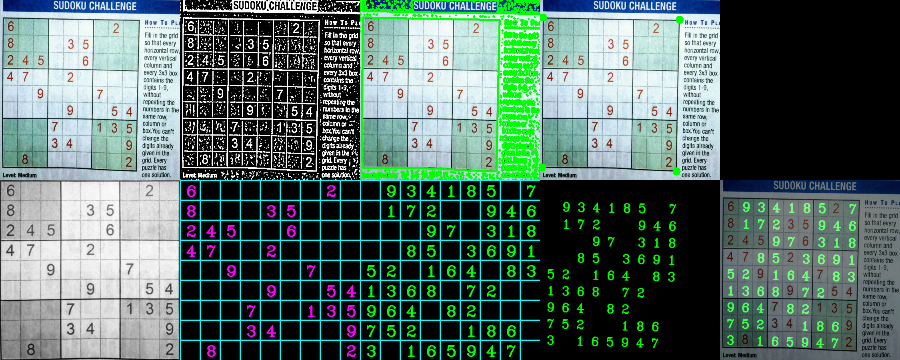

-1

In [173]:
img_solved = drawGrid(img_solved)
img_digits = drawGrid(img_digits)
img_stacked = stackImages(0.4,[[img,img_threshold,img_contours,img_biggest,img_blank],[Wraped_img,img_digits,img_solved,UNWraped_img,solution_IMG ]])
cv2_imshow(img_stacked)
cv.waitKey(0)